# **Fruit Image Recognition with TensorFlow**

The following Image Recognition Model is built with tensorflow and has been trained to recognize five different fruits: bananas, grapes, blueberries, apples and oranges.
<br><br>
For this project I closely followed this official tutorial by TensorFlow: https://www.tensorflow.org/tutorials/images/classification

<br>

----

<br>



##**Setup**
First, connect this notebook to google drive:

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Next, install dependencies and import libraries

<br>

----

<br>



##**Download and explore the dataset**

In [4]:
!pip install --upgrade pip
!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, Sequential
import matplotlib.pyplot as plt
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 63.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


Next unzip the data

In [5]:
%cd /content/drive/MyDrive/

!mkdir -p /content/data/train /content/data/test

# unzip train & test archives into a single data folder
!unzip -o -q fruit_data_train.zip -d /content/data/train
!unzip -o -q fruit_data_test.zip  -d /content/data/test

# verify
!find /content/data -maxdepth 2 -type d


/content/drive/MyDrive
/content/data
/content/data/train
/content/data/train/grape
/content/data/train/blueberry
/content/data/train/orange
/content/data/train/banana
/content/data/train/apple
/content/data/test
/content/data/test/grape
/content/data/test/blueberry
/content/data/test/orange
/content/data/test/banana
/content/data/test/apple


<br>

----

<br>



##**Load data using a Keras utility**

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 100
img_width  = 100

Create the datasets and use 80% of the images for training and 20% for validation

In [7]:
# training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/data/train',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)
# validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/data/train',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)
# testing dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/data/test',
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 3756 files belonging to 5 classes.
Using 3005 files for training.
Found 3756 files belonging to 5 classes.
Using 751 files for validation.
Found 2009 files belonging to 5 classes.


Note: train_ds, val_ds and test_ds are datasets containing tuples of (images, labels).

<br>

----

<br>

##**Examine class names**

In [8]:
class_names = train_ds.class_names
print(class_names)

['apple', 'banana', 'blueberry', 'grape', 'orange']


<br>

----

<br>



##**Configure the dataset for performance**

Use prefetching to yield data from disk without I/O blocking.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

<br>

----

<br>



##**Visualize the data**

Print some example images, one from each class

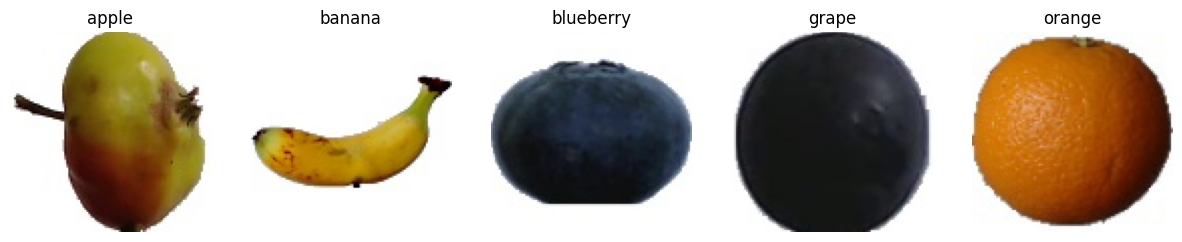

In [10]:
# path to the directory containing training images
DATA_DIR = '/content/data/train'

# Display one image per class in a horizontal row
plt.figure(figsize=(15, 3))

for index, class_name in enumerate(class_names):
    # Construct the path to the class folder
    class_folder = os.path.join(DATA_DIR, class_name)
    # Pick the first image file in the class folder
    first_image_name = os.listdir(class_folder)[0]
    image_path       = os.path.join(class_folder, first_image_name)
    # Load the image and resize it to 100x100 pixels
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(100, 100))
    # Plot the image in the i-th subplot
    ax = plt.subplot(1, len(class_names), index + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

<br>

----

<br>



A tensor is basically a multi-dimensional array defined:

<table style="font-size:18px; border-collapse: separate; border-spacing: 0 12px;">
  <tr>
    <th style="padding:8px 12px;">Rank</th>
    <th style="padding:8px 12px;">Shape example</th>
    <th style="padding:8px 12px;">What it represents</th>
  </tr>
  <tr>
    <td style="padding:8px 12px;">0-D</td>
    <td style="padding:8px 12px;"><code>()</code></td>
    <td style="padding:8px 12px;">Scalar: a single number (“42”)</td>
  </tr>
  <tr>
    <td style="padding:8px 12px;">1-D</td>
    <td style="padding:8px 12px;"><code>(5,)</code></td>
    <td style="padding:8px 12px;">Vector: a list of 5 elements ([1,2,3,4,5])</td>
  </tr>
  <tr>
    <td style="padding:8px 12px;">2-D</td>
    <td style="padding:8px 12px;"><code>(3, 4)</code></td>
    <td style="padding:8px 12px;">Matrix: a 3×4 table of numbers</td>
  </tr>
  <tr>
    <td style="padding:8px 12px;">3-D</td>
    <td style="padding:8px 12px;"><code>(32, 100, 100)</code></td>
    <td style="padding:8px 12px;">Stack: 32 grayscale 100×100 images</td>
  </tr>
  <tr>
    <td style="padding:8px 12px;">4-D</td>
    <td style="padding:8px 12px;"><code>(32, 100, 100, 3)</code></td>
    <td style="padding:8px 12px;">Batch: 32 RGB images</td>
  </tr>
</table>


And so on...


<img src="https://kindsonthegenius.com/blog/wp-content/uploads/2018/11/Simple-2BTutorials-2Bon-2BTensors.jpg?189db0&189db0" width="600px" />


`image_batch` is a 4D tensor of shape

(`batch_size`, `img_height`, `img_width`, `num_channels`)

`label_batch` is a 1D tensor of shape

(`batch_size`,)

containing the integer class IDs (0…4).

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 100, 100, 3)
(32,)


The image_batch is a tensor of the shape (32, 100, 180, 3). This is a batch of 32 images of shape 100x100x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.



<br>

----

<br>

##**Standardize the data**

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling

In [12]:
normalization_layer = layers.Rescaling(1./255)

<br>

----

<br>

##**A basic Keras model**

Here we create the ML model.


*   First, we get the number of classes (one for each fruit so 5).

*   Then we normalize the RGB channels. As is, the RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here we  standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling

*   Then random data augmentation is introduced by scaling and rotating the pictures randomly.

*   Then we perform three pairs of convolution and pooling layers.

`Convolutional layers (Conv2D) scan the input image (or feature maps) with small learnable filters to detect patterns like edges, textures, or more complex shapes.`

`Pooling layers (MaxPooling2D) then down‑sample the feature maps to reduce the spatial size and makes the network more robust to small shifts.`

*   Then, the final block of layers takes the “features” learned by the convolutional blocks and turns them into your actual fruit predictions:

`Flatten: Squashes the 3D feature maps into a 1D list.`

`Dropout(0.5): Randomly zeroes out 50% of those list entries during training.`

`Dense(128, ReLU): Learns combinations of those features in a fully‑connected layer with 128 neurons.`

`Dense(num_classes, Softmax): Produces one probability per fruit class (summing to 1) so you can pick the most likely fruit.`

Source: https://www.tensorflow.org/tutorials/images/classification


In [13]:
num_classes = len(class_names)

model = Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),

    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax'),
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Compile the model

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model Summary

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 100, 100, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,204,005 (4.59 MB)

 Trainable params: 1,204,005 (4.59 MB)

 Non-trainable params: 0 (0.00 B)

Train the model

In [16]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


94/94 ━━━━━━━━━━━━━━━━━━━━ 47s 427ms/step - accuracy: 0.7224 - loss: 0.6784 - val_accuracy: 1.0000 - val_loss: 0.0424
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 34s 360ms/step - accuracy: 0.9770 - loss: 0.0852 - val_accuracy: 0.9973 - val_loss: 0.0116
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 34s 362ms/step - accuracy: 0.9917 - loss: 0.0294 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 354ms/step - accuracy: 0.9935 - loss: 0.0187 - val_accuracy: 1.0000 - val_loss: 0.0045
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 35s 373ms/step - accuracy: 0.9768 - loss: 0.0681 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 43s 393ms/step - accuracy: 0.9976 - loss: 0.0066 - val_accuracy: 1.0000 - val_loss: 4.3008e-04
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 38s 365ms/step - accuracy: 0.9977 - loss: 0.0067 - val_accuracy: 0.9973 - val_loss: 0.0071
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 35s 373ms/step - accuracy: 0.9961 - loss: 0.0096 - val_accuracy: 1

Visualize training results

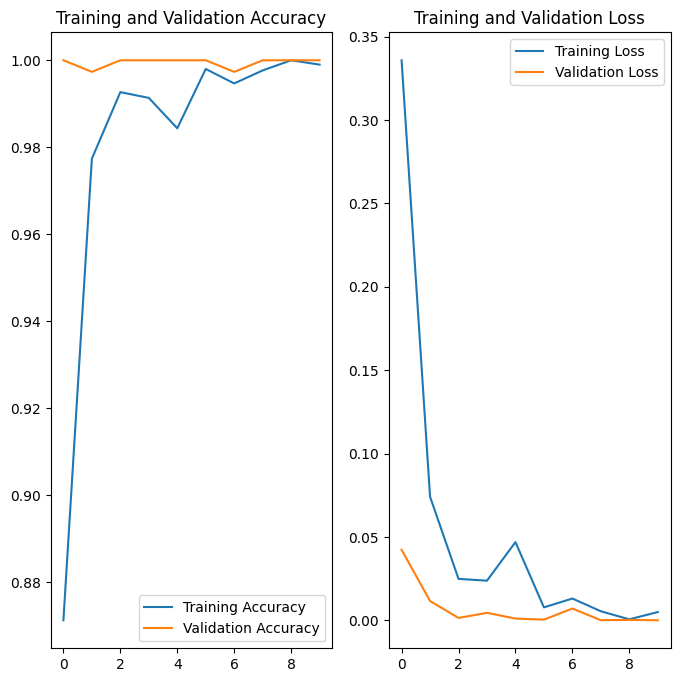

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

These results show a high level of accuracy in the ML model, even after just a few epochs. Now let's evaluate it on the test set to validate these results.

<br>

----

<br>

# Evaluate Model Performance on the Test Set

We can use the following evaluate function:
```
model.evaluate(test_ds)

```


In [18]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4%}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.9709 - loss: 0.4857
Test Loss: 0.5728
Test Accuracy: 97.0632%


These results show us that while the model generalizes well, it is not perfect. Though we could take some diagnostic steps here to try and improve the model, I am satisfied with these results for the time being as my main goal with this colab was to familarize myself with the TensorFlow software.